# Housing Prices Competition: Preprocessing and Predictions 🏘️💰📈

<br>

<img src="https://images.unsplash.com/photo-1508404140693-f3a1a3e2a85d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1338&q=80" width = 600>
<center>Photo by Annie Spratt (Unsplash)</center>

<br>

**Table of Contents**

- [Overview](#Overview)
- [Libraries and Default Parameters](#Libraries-and-Default-Parameters)
- [Getting the Data](#Getting-the-Data)
- [Data Preprocessing](#Data-Preprocessing)
    - [Missing Values](#Missing-Values) <br>
    - [Label Encoding and Factorizing Variables](#Label-Encoding-and-Factorizing-Variables) <br>
    - [Dealing with Outliers](#Dealing-with-Outliers) <br>
    - [Feature Engineering](#Feature-Engineering) <br>
    - [Feature Selection](#Feature-Selection) <br>
    - [One-hot Encoding](#One-hot-Encoding) <br>
    - [Scaling](#Scaling)
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models) <br>
    - [Model Tuning](#Model-Tuning) <br>
    - [Comparison](#Comparison) <br>
    - [Feature Importance](#Feature-Importance)
- [Test Set](#Test-Set)
- [Submission](#Submission)
- [References](#References)
- [Conclusions](#Conclusions)


<br>

# Overview



<br>

# Libraries and Default Parameters

We start by importing the necessary libraries and setting some parameters for the whole notebook. We will mainly use three Python libraries:

- Pandas for handling and analysing data,
- Seaborn and Matplotlib for data visualisation, and
- Scikit-learn for building Machine Learning models.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 2)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

import missingno as msno

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('fivethirtyeight')
main_color  = '#B7C3F3'
edgecolor = 'black'

font_size = 14

plt.rcParams['axes.edgecolor'] = '0.15'
plt.rcParams['axes.linewidth']  = 1
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2

plt.rcParams['lines.linewidth'] = 3

In [3]:
random_state = 42
scoring = 'neg_mean_absolute_error'

<br>

# Getting the Data

The whole dataset has already been split into a training set ('train.csv') and a test set ('test.csv'). We can use the `read_csv()` method to load them as Pandas DataFrames:

In [4]:
train_df = pd.read_csv('Datasets/train_new.csv')
test_df = pd.read_csv('Datasets/test_new.csv')

print('DataFrames loaded successfully!\n')
print('The train set contains {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print(' The test set contains {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

DataFrames loaded successfully!

The train set contains 1460 rows and 80 columns
 The test set contains 1459 rows and 79 columns


We are going to **merge** the two DataFrames into one. The new dataframe will have NaN in the 'SalePrice' column for instances of the test set:

In [5]:
all_data = pd.concat([train_df, test_df]).reset_index(drop=True)

print('The combined dataset has {} rows and {} columns'.format(all_data.shape[0], all_data.shape[1]))
print("Number of NaN values in 'SalePrice': ",all_data['SalePrice'].isnull().sum())

The combined dataset has 2919 rows and 80 columns
Number of NaN values in 'SalePrice':  1459


<br> 

# Data Preprocessing

<br>

## Missing Values

Unfortunately, many attributes contain missing values. We can see both the count and the percentage of missing values for each column:

In [6]:
X = all_data[all_data.columns.difference(['SalePrice'])]

no_features = (X.isnull().sum(axis=0) != 0).sum()
print('There are {} features with missing values.'.format(no_features))

There are 0 features with missing values.


<br>

## Label Encoding and Factorizing Variables

In [7]:
qualities = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for column in [
        'PoolQC', 'FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtQual',
        'BsmtCond', 'KitchenQual', 'ExterQual', 'ExterCond', 'HeatingQC'
]:
    all_data[column] = all_data[column].replace(qualities)

In [8]:
all_data['LotShape'] = all_data['LotShape'].replace({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3})
all_data['GarageFinish'] = all_data['GarageFinish'].replace({'None':0, 'Unf':1, 'RFn':2, 'Fin':3})
all_data['BsmtExposure'] = all_data['BsmtExposure'].replace({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})

all_data['BsmtFinType1'] = all_data['BsmtFinType1'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].replace({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})

all_data['MasVnrType'] = all_data['MasVnrType'].replace({'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2})

all_data['Functional'] = all_data['Functional'].replace({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})

all_data['LandSlope'] = all_data['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl':2})
all_data['CentralAir'] = all_data['CentralAir'].map({'N': 0, 'Y': 1})
all_data['Street'] = all_data['Street'].map({'Grvl': 0, 'Pave': 1})
all_data['PavedDrive'] = all_data['PavedDrive'].map({'N':0, 'P':1, 'Y':2})

<br>

## Dealing with Outliers

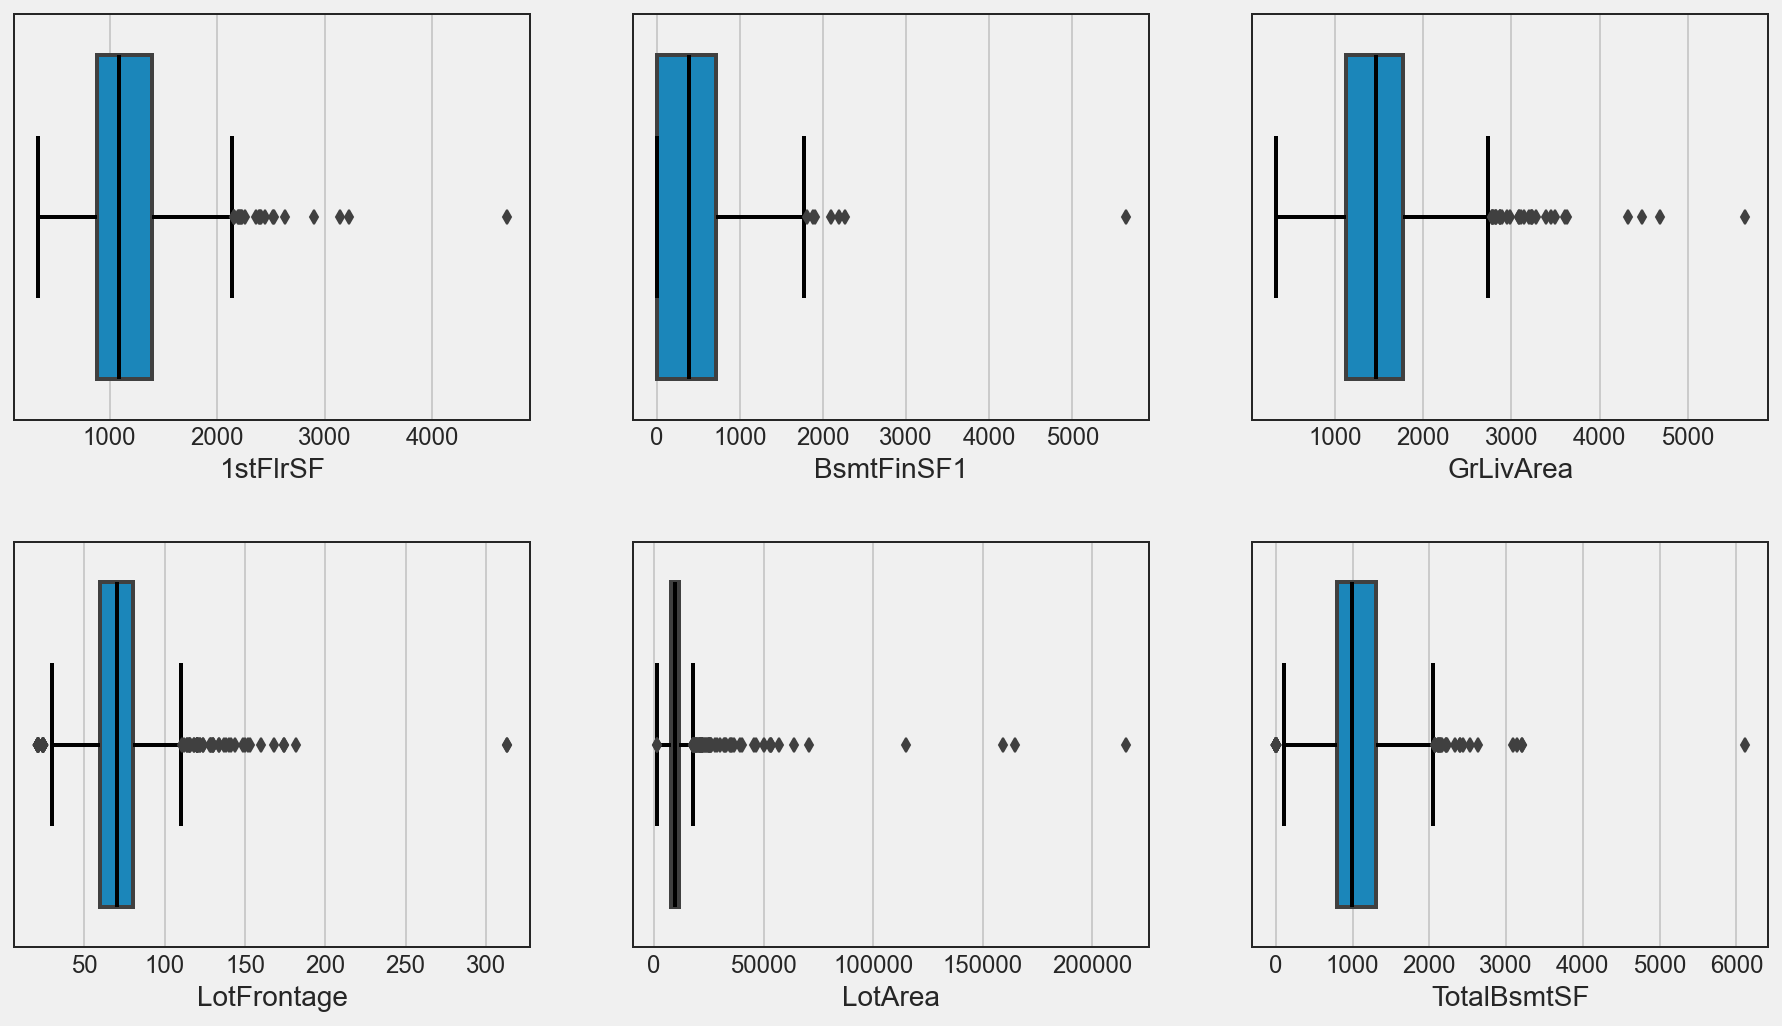

In [9]:
out_col = ['1stFlrSF', 'BsmtFinSF1', 'GrLivArea', 'LotFrontage', 'LotArea', 'TotalBsmtSF']

fig = plt.figure(figsize=(14, 8), facecolor='#f0f0f0')

for index, col in enumerate(out_col):
    
    plt.subplot(2, 3, index + 1)
    sns.boxplot(x=col, data=train_df, 
                linewidth=2,
                medianprops={'color': edgecolor},
                capprops={'color': edgecolor},
                whiskerprops={'color': edgecolor},)
    
plt.subplots_adjust(hspace=0.3);

In [10]:
idx_drop = []
idx_drop.extend(train_df[train_df['1stFlrSF'] > 3_000].index)
idx_drop.extend(train_df[train_df['BsmtFinSF1'] > 4_000].index)
idx_drop.extend(train_df[train_df['GrLivArea'] > 4_000].index)
idx_drop.extend(train_df[train_df['LotFrontage'] > 200].index)
idx_drop.extend(train_df[train_df['LotArea'] > 100_000].index)
idx_drop.extend(train_df[train_df['TotalBsmtSF'] > 5_000].index)

idx_drop = list(set(idx_drop))
idx_drop

[706, 934, 313, 523, 335, 496, 1298, 691, 249, 1182]

In [11]:
all_data = all_data.drop(idx_drop)
all_data.reset_index(drop = True);

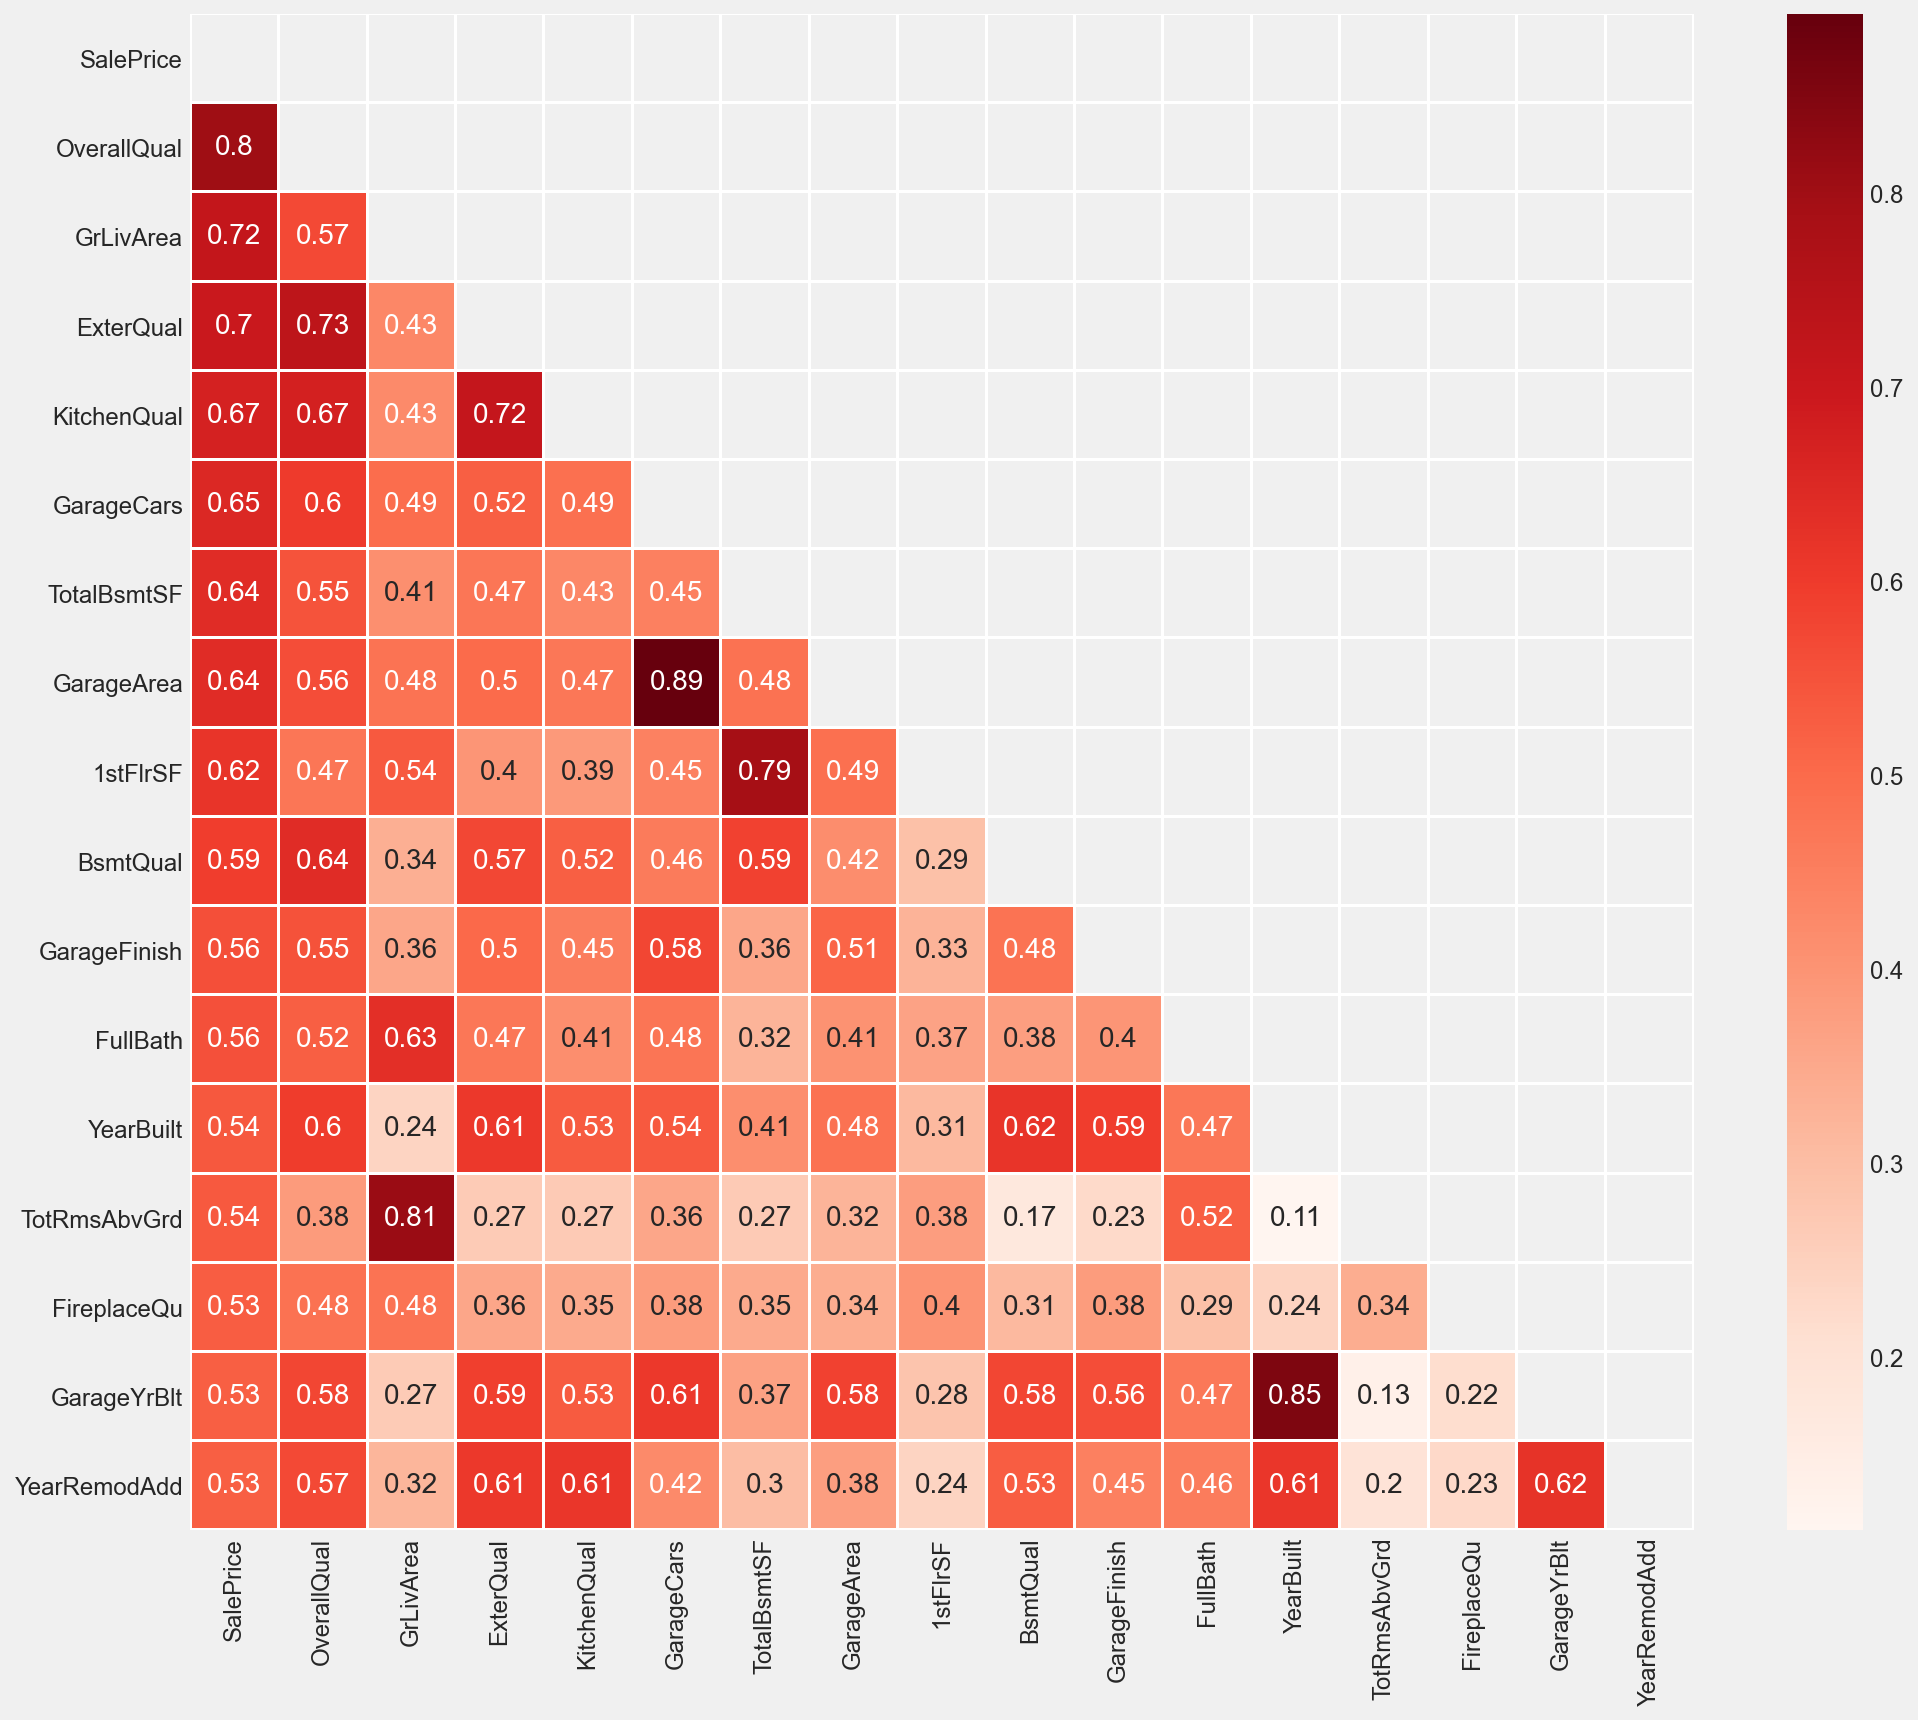

In [12]:
numeric_atts = all_data.select_dtypes(exclude=['object'])
cat_atts = all_data.select_dtypes(include=['object'])

correlations = numeric_atts.select_dtypes(exclude=['object']).corr()
correlations = correlations[['SalePrice']].sort_values(by=['SalePrice'],
                                                       ascending=False)
indeces = correlations.iloc[:17].index
corr_matrix = numeric_atts.select_dtypes(exclude=['object']).corr().loc[indeces, indeces]

plt.figure(figsize=(15, 13))

sns.heatmap(corr_matrix, annot=True, mask=np.triu(corr_matrix), linewidth=1, cmap='Reds');

<br>

## Feature Engineering

Correlation with 'SalePrice': 
   TotalBath: 0.63
   FullBath: 0.56
   BsmtFullBath: 0.23
   HalfBath: 0.29
   BsmtHalfBath: -0.04


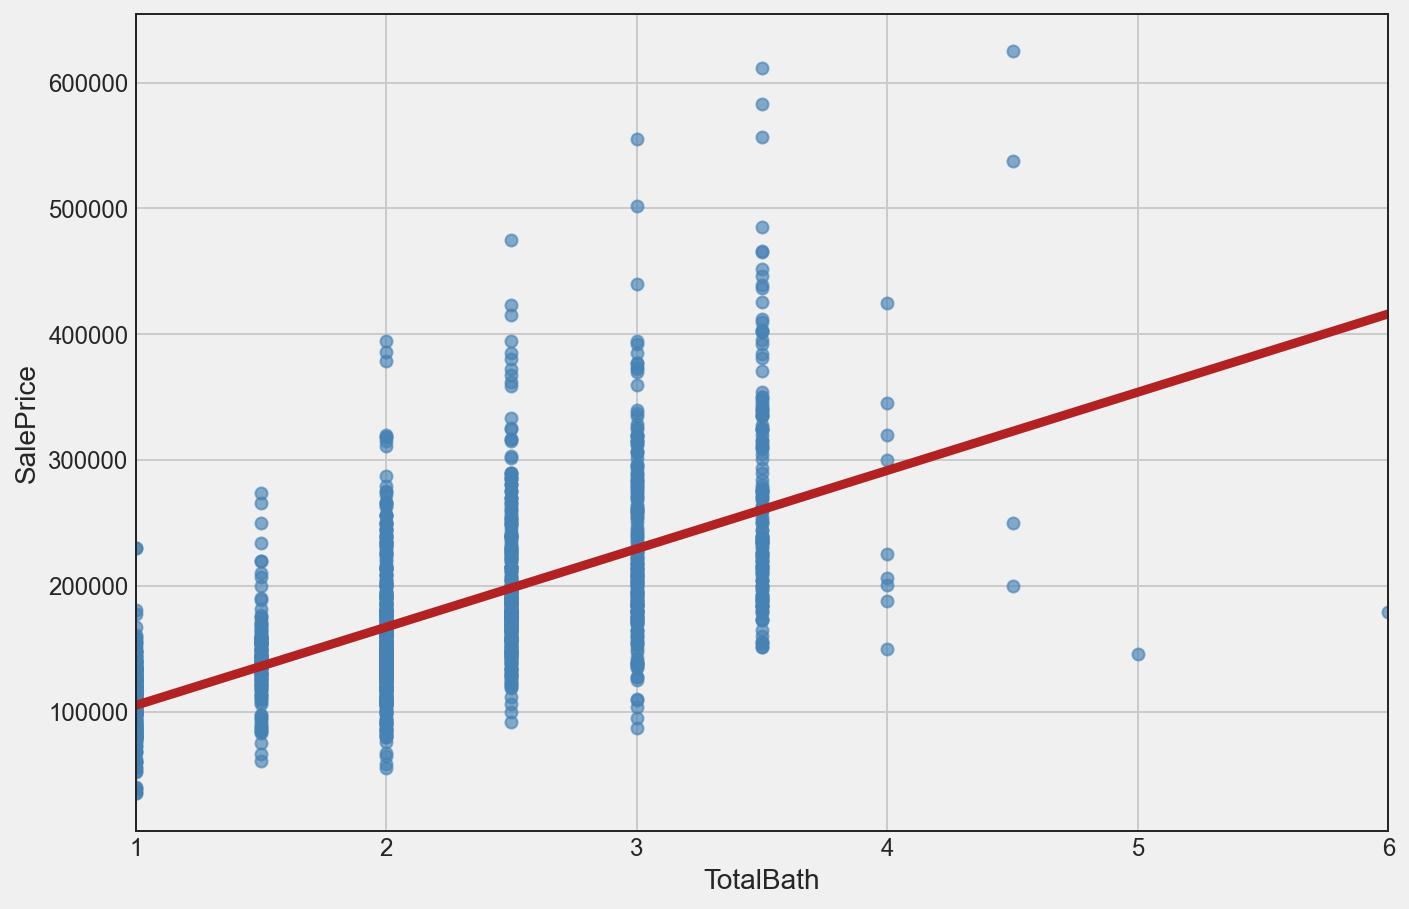

In [13]:
all_data['TotalBath'] = all_data['FullBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['HalfBath'] + 0.5 * all_data['BsmtHalfBath']

print("Correlation with 'SalePrice': ")

for col in ['TotalBath', 'FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']:
    cor = all_data[[col, 'SalePrice']].corr().loc[col, 'SalePrice']
    print('   ' + col + ': ' + str(np.round(cor, 2)))

fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='TotalBath',
            y='SalePrice',
            data=all_data,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax);

<br>

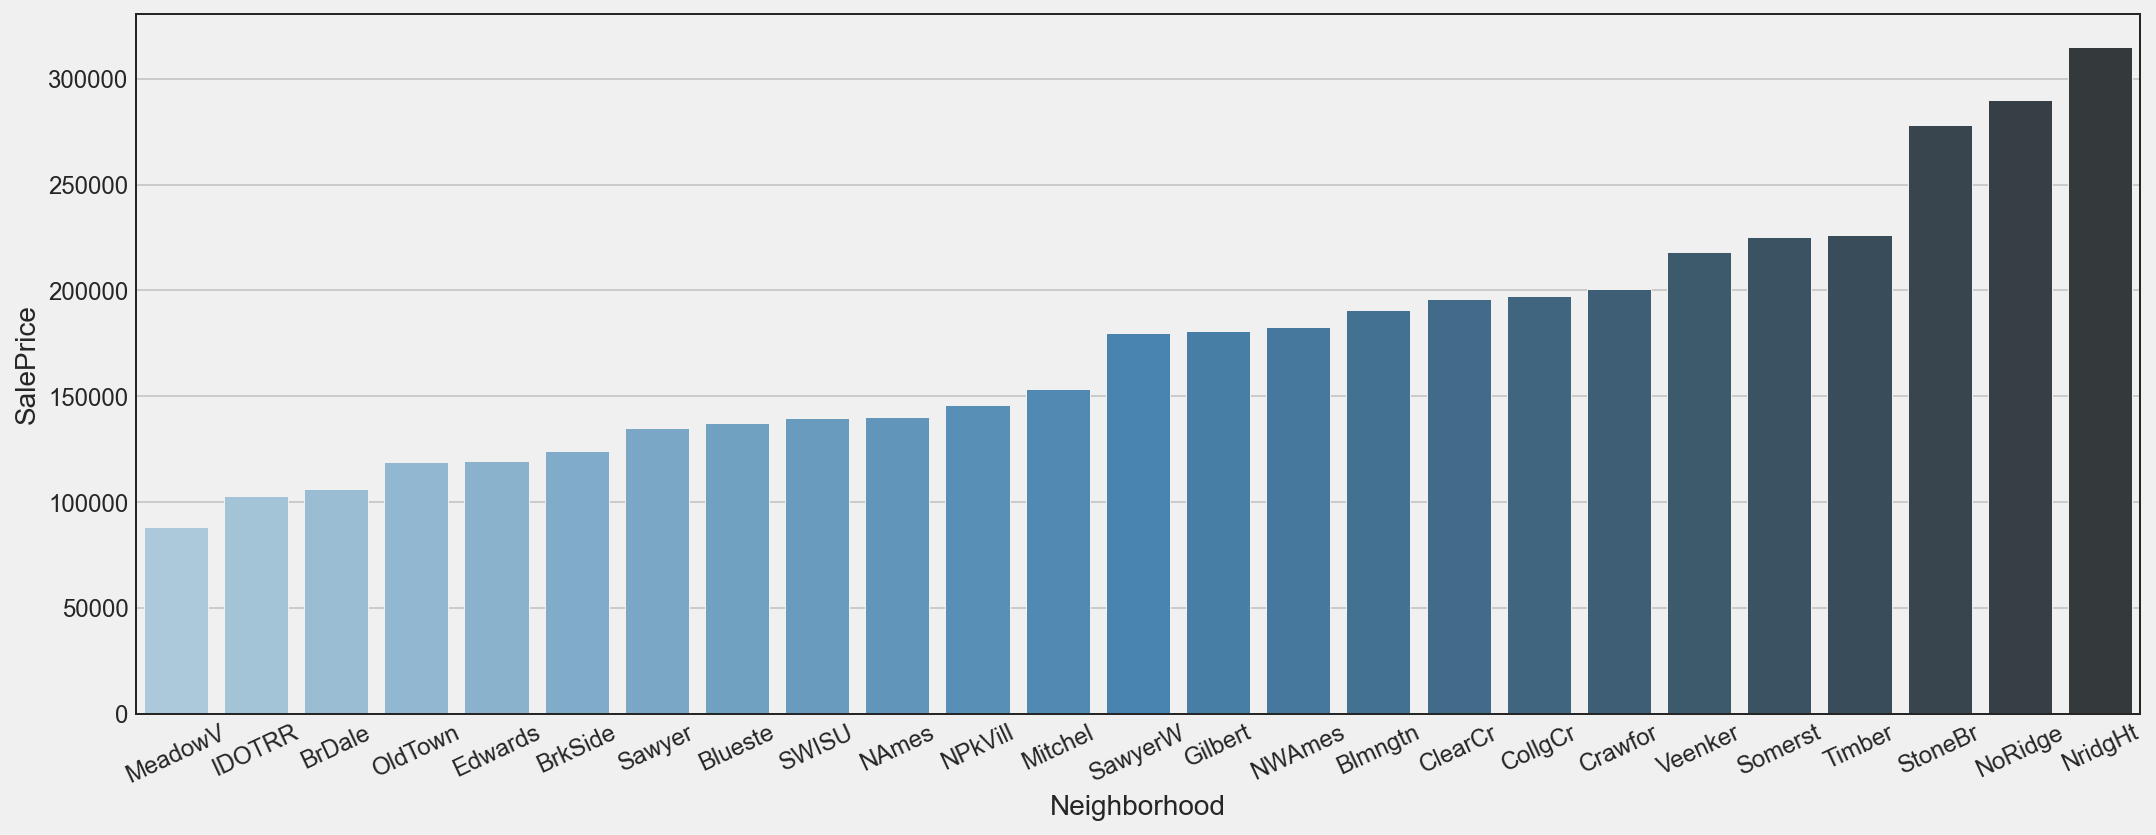

In [14]:
neighbour_gb = all_data.groupby('Neighborhood')['SalePrice'].median()
neighbour_gb = neighbour_gb.to_frame().sort_values(by='SalePrice',
                                                   ascending=True)

fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(x=neighbour_gb.index,
            y=neighbour_gb['SalePrice'],
            palette='Blues_d',
            ax=ax)

ax.tick_params(axis='x', rotation=25);

In [15]:
def label_neighborhoods(row):
    if row in ['StoneBr', 'NridgHt', 'NoRidge']:
        return 2
    elif row in ['MeadowV', 'IDOTRR', 'BrDale']:
        return 0
    else:
        return 1


all_data['Neigh_Rich'] = all_data['Neighborhood'].apply(lambda row: label_neighborhoods(row))
all_data['Neigh_Rich'].value_counts()

1    2464
2     285
0     160
Name: Neigh_Rich, dtype: int64

<br>

Correlation with 'SalePrice'
   TotalSqFeet: 0.82
   GrLivArea: 0.72
   TotalBsmtSF: 0.64


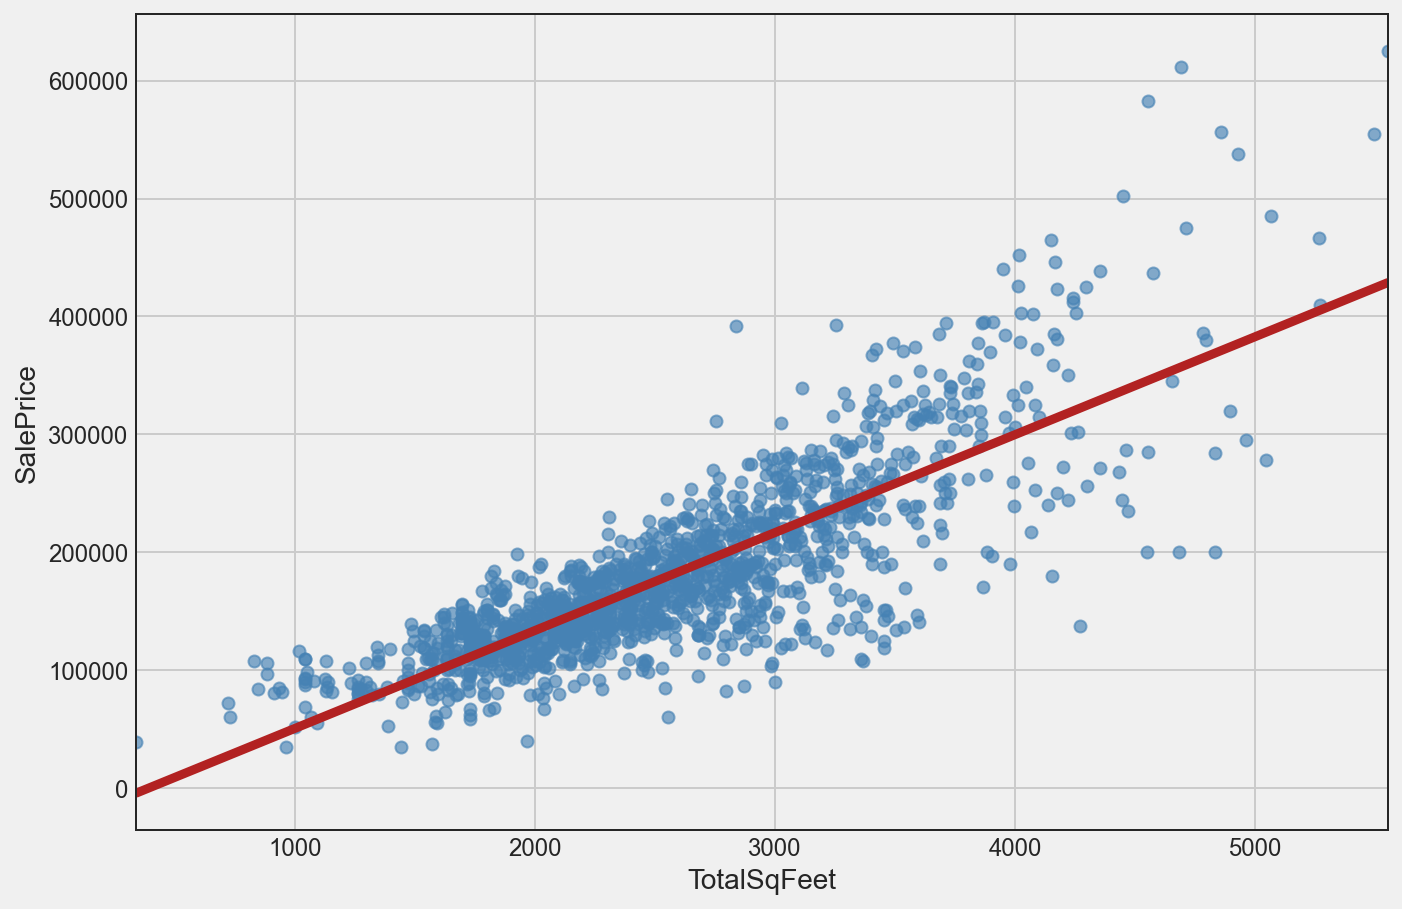

In [16]:
all_data['TotalSqFeet'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']

print("Correlation with 'SalePrice'")
for col in ['TotalSqFeet', 'GrLivArea', 'TotalBsmtSF']:
    cor = all_data[[col, 'SalePrice']].corr().loc[col, 'SalePrice']
    print('   ' + col + ': ' + str(np.round(cor, 2)))

fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='TotalSqFeet',
            y='SalePrice',
            data=all_data,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax);

<br>

<br>

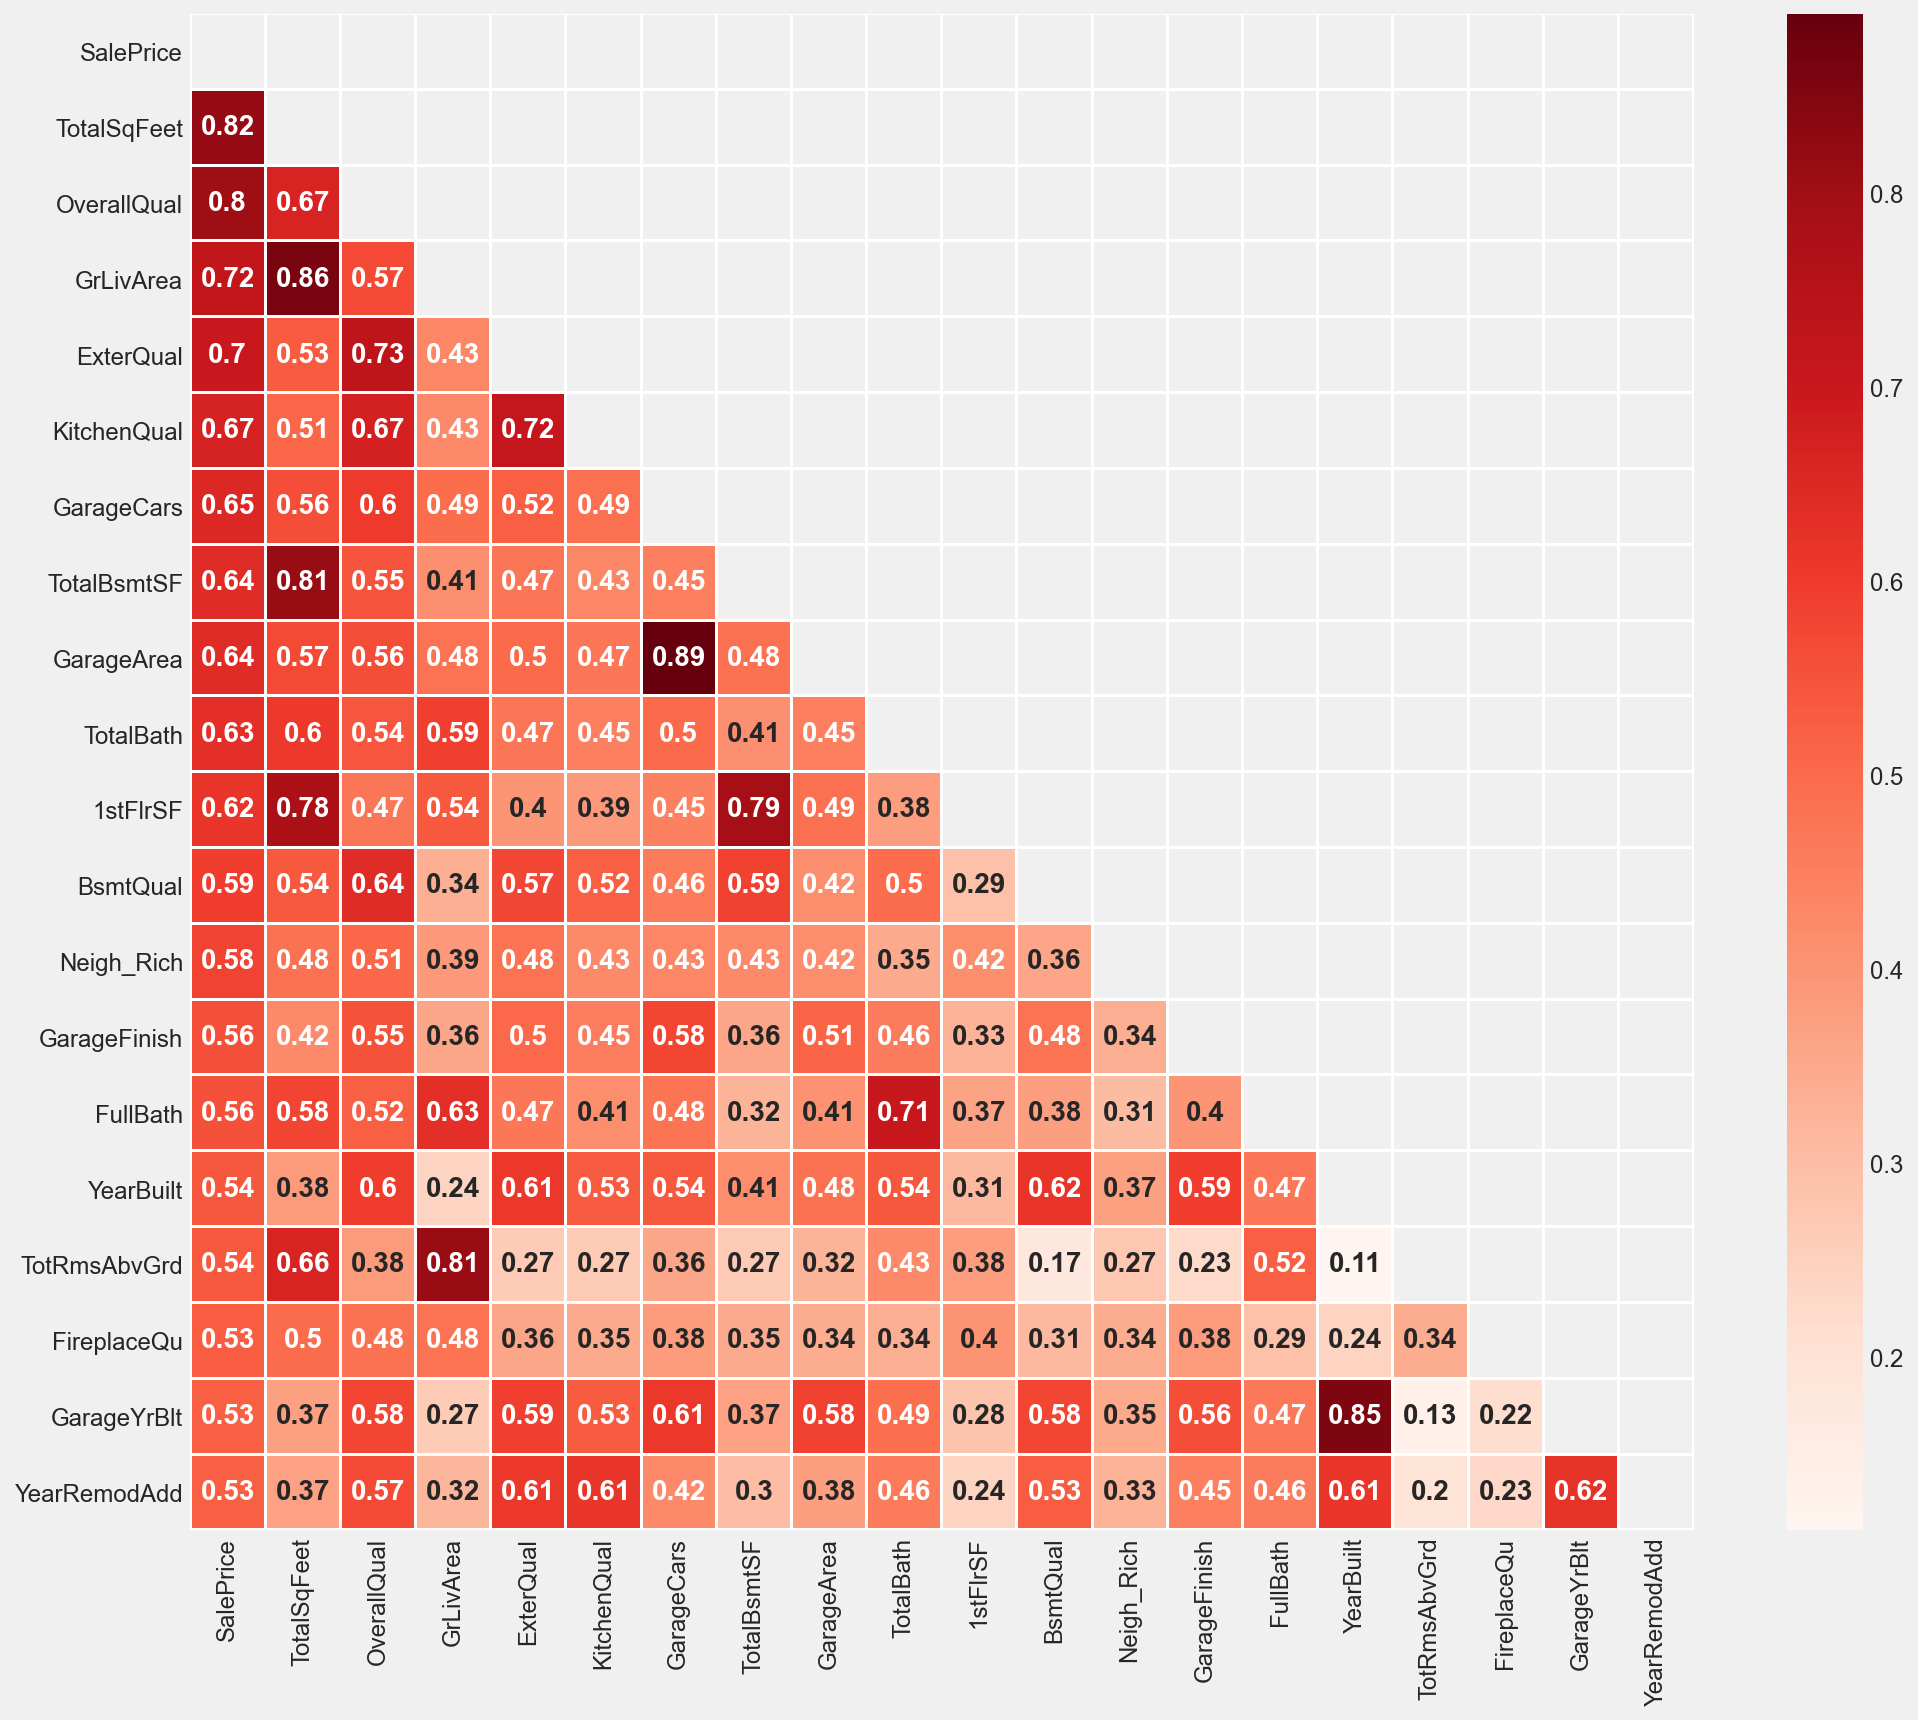

In [17]:
numeric_atts = all_data.select_dtypes(exclude=['object'])
cat_atts = all_data.select_dtypes(include=['object'])

correlations = numeric_atts.select_dtypes(exclude=['object']).corr()
correlations = correlations[['SalePrice']].sort_values(by=['SalePrice'],
                                                       ascending=False)
indeces = correlations.iloc[:20].index

corr_matrix = numeric_atts.select_dtypes(exclude=['object']).corr().loc[indeces, indeces]
matrix = np.triu(corr_matrix)

plt.figure(figsize=(15, 13))

sns.heatmap(corr_matrix,
            annot=True,
            mask=matrix,
            linewidth=1,
            annot_kws={'weight': 'bold',
                       'size': 14},
            cmap='Reds');

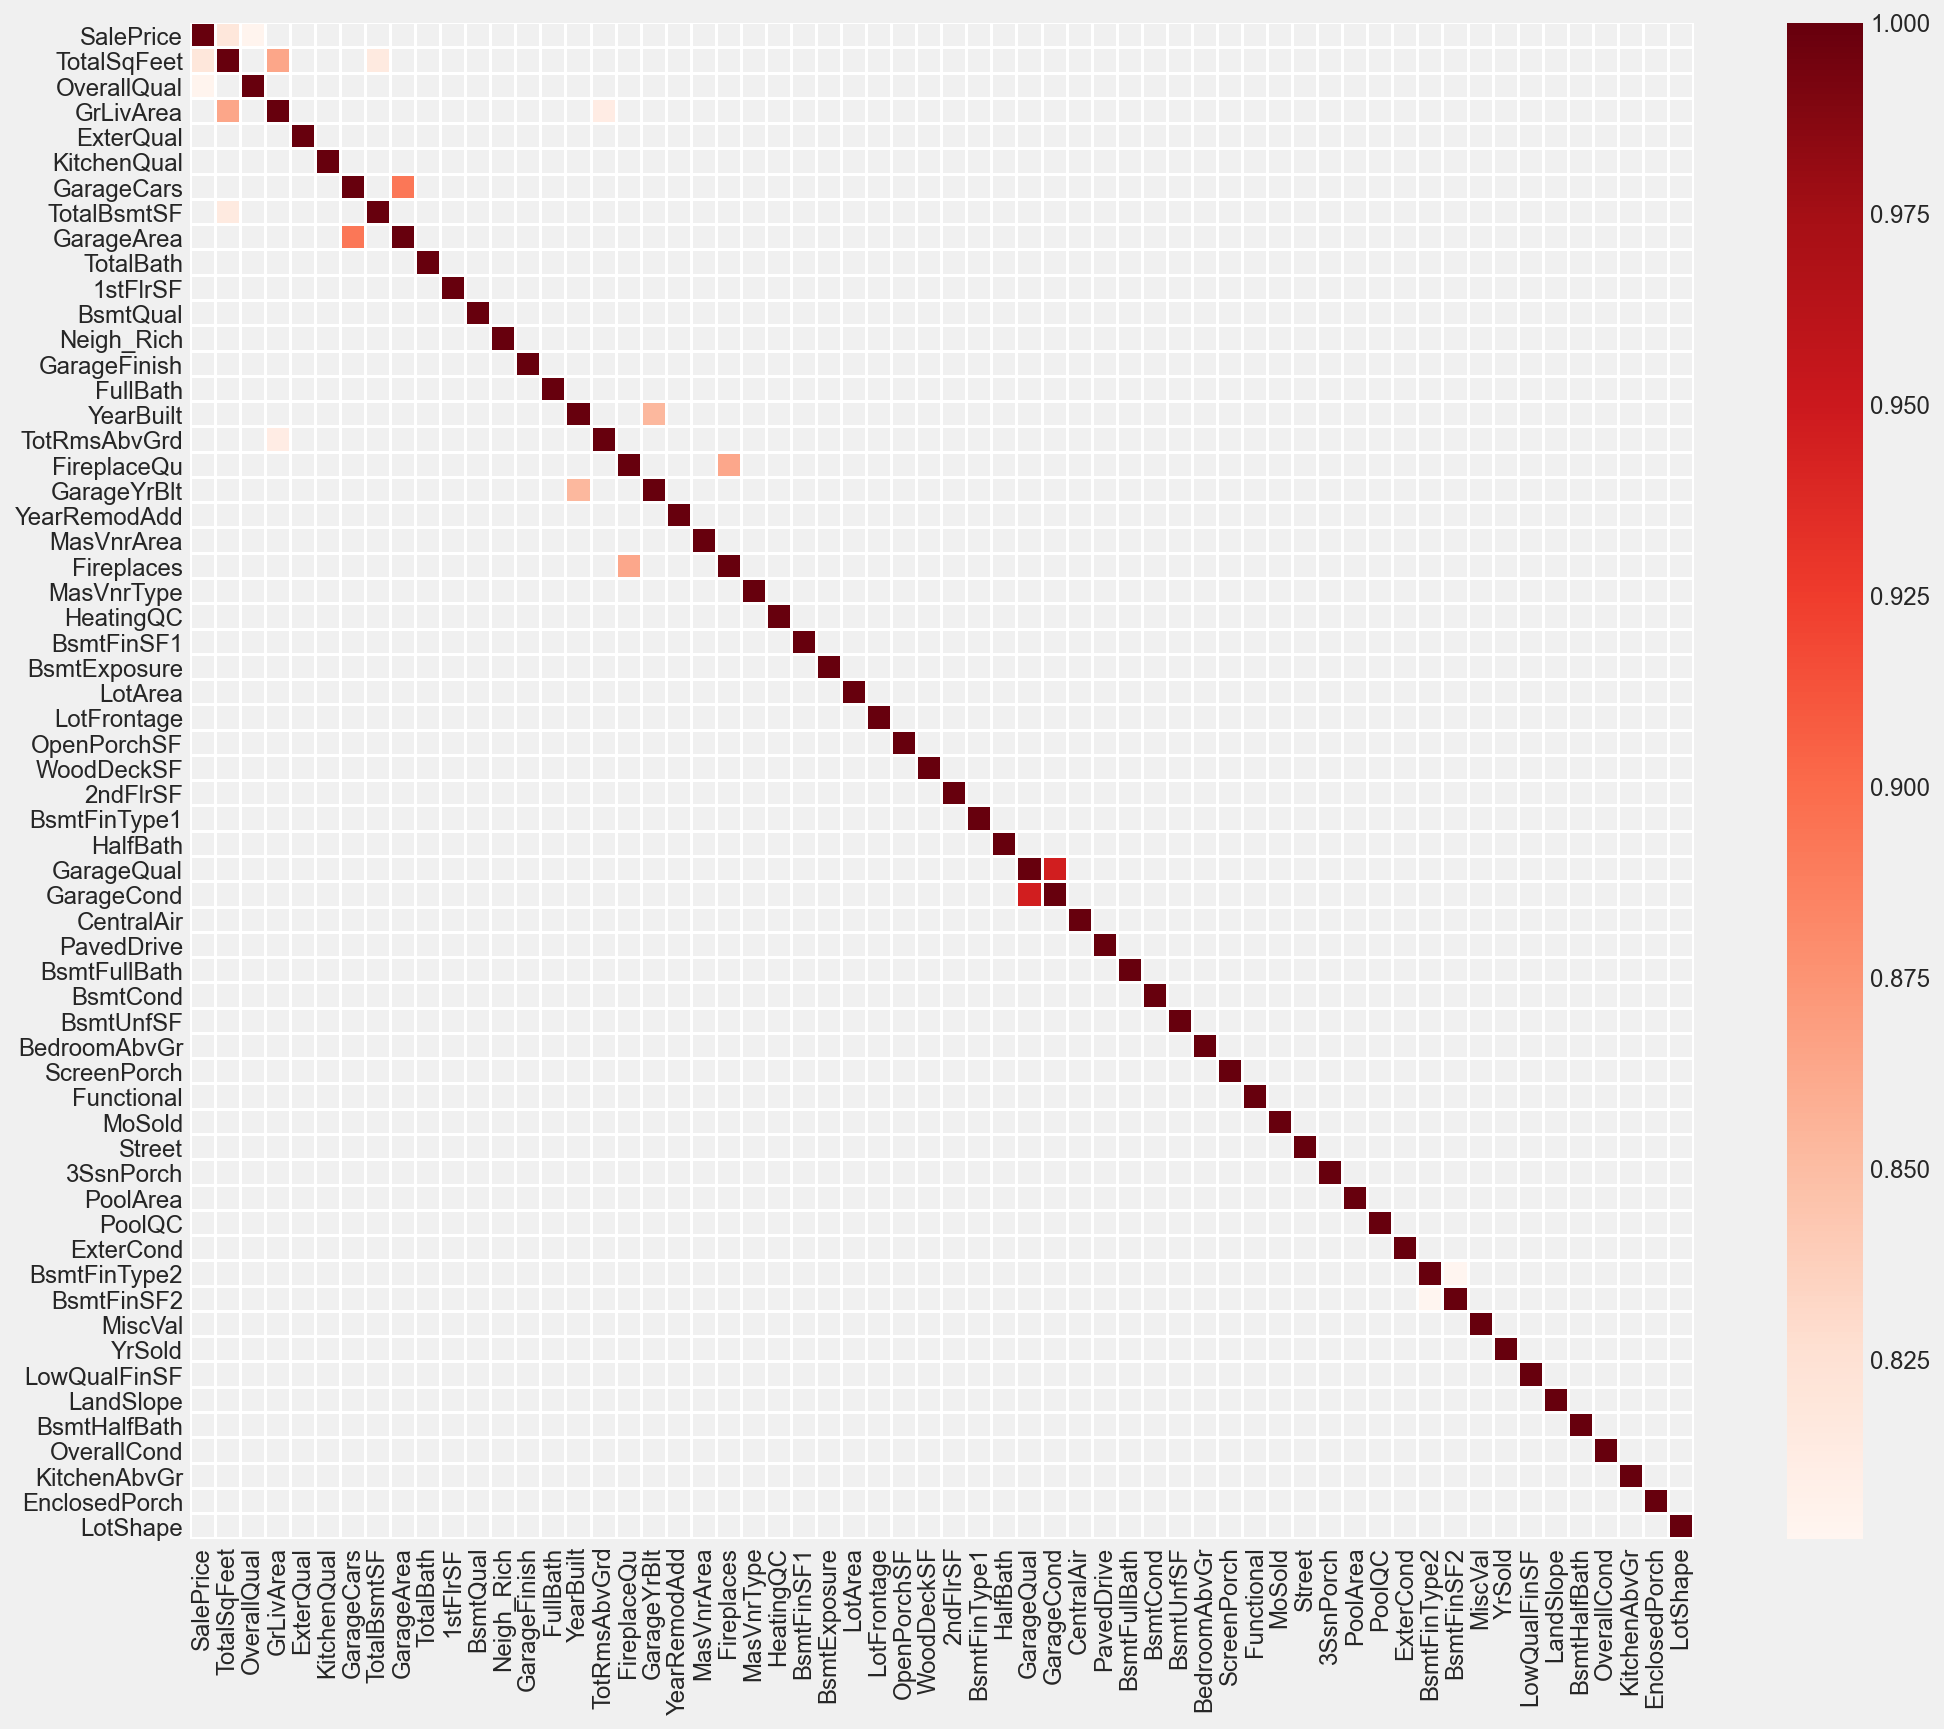

In [18]:
plt.figure(figsize=(15, 13))

correlations = numeric_atts.select_dtypes(exclude=['object']).corr()
correlations = correlations[['SalePrice']].sort_values(by=['SalePrice'],
                                                       ascending=False)
indeces = correlations.index

corr_matrix = numeric_atts.select_dtypes(exclude=['object']).corr().loc[indeces, indeces]
sns.heatmap(corr_matrix, mask=corr_matrix < 0.80, linewidth=1, cmap='Reds');

<br>

## Feature Selection

In [19]:
cols_drop = ['Fireplaces', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'TotalBsmtSF', 'GrLivArea']

all_data.drop(cols_drop, axis=1, inplace=True)

In [20]:
thd = 0.95
cols_drop = []

for column in all_data.drop('SalePrice', axis=1):

    most_freq_value = all_data[column].value_counts(normalize=True).iloc[0]
    if (most_freq_value > thd):
        cols_drop.append(column)
        print('{}: {}% same value'.format(column, np.round(most_freq_value, 3)))

all_data.drop(cols_drop, axis=1, inplace=True)
print('\nFeatures with low variance dropped successfully!')

Street: 0.996% same value
Utilities: 1.0% same value
LandSlope: 0.953% same value
Condition2: 0.99% same value
RoofMatl: 0.986% same value
Heating: 0.985% same value
LowQualFinSF: 0.986% same value
KitchenAbvGr: 0.954% same value
3SsnPorch: 0.987% same value
PoolArea: 0.996% same value
PoolQC: 0.997% same value
MiscFeature: 0.965% same value
MiscVal: 0.965% same value

Features with low variance dropped successfully!


In [21]:
numeric_atts = all_data.select_dtypes(exclude=['object'])
cat_atts = all_data.select_dtypes(include=['object'])

print('    Number of Numeric columns: ', len(numeric_atts.columns))
print('Number of Categorical columns: ', len(cat_atts.columns))

    Number of Numeric columns:  46
Number of Categorical columns:  18


<br>

---

In [22]:
categorical = cat_atts.columns

ordinal = [
    'FireplaceQu', 'GarageQual', 'BsmtQual', 'BsmtCond', 'KitchenQual',
    'ExterQual', 'ExterCond', 'HeatingQC', 'LotShape', 'GarageFinish',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Functional',
    'CentralAir', 'PavedDrive', 'OverallCond', 'OverallQual', 'BsmtFullBath',
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
    'GarageCars', 'TotalBath', 'Neigh_Rich'
]

binary = ['CentralAir']

continuous = [
    col for col in all_data.select_dtypes(exclude=['object'])
    if col not in (ordinal or binary)
]

continuous.remove('SalePrice')

len(continuous)

17

<br>

## One-hot Encoding

In [23]:
all_data_before = all_data.copy()

all_data = pd.get_dummies(all_data, columns=categorical, drop_first=True)
print ('One-hot encoding completed!\n')
print ('Shape before: ', all_data_before.shape)
print (' Shape after: ', all_data.shape)

One-hot encoding completed!

Shape before:  (2909, 64)
 Shape after:  (2909, 183)


<br>

## Scaling

In [24]:
idx = all_data['SalePrice'].notnull().sum()

train_df = all_data[:idx]

y_train = np.log1p(train_df['SalePrice'])
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [25]:
X_train = all_data[:idx]
X_test = all_data[idx:]

print ('Splitting: Done!')

Splitting: Done!


In [26]:
scaler = StandardScaler()
scaler.fit(X_train[continuous])

X_train[continuous] = scaler.transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])

<br>

# Building Machine Learning Models

In [27]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_train_original = X_train.copy()
y_train_original = y_train.copy()

X_test_original = X_test.copy()

In [28]:
X_test = X_train.iloc[1250:]
y_test = y_train.iloc[1250:]

X_train = X_train.iloc[:1250]
y_train = y_train.iloc[:1250]

In [29]:
y_pred = np.full(len(y_train), y_train.mean())
mae_base_mean = mean_absolute_error(y_train, y_pred)
print('Mean: ', mae_base_mean)

y_pred = np.full(len(y_train), y_train.median())
mae_base_median = mean_absolute_error(y_train, y_pred)
print('Median: ', mae_base_median)

Mean:  0.30706991437455233
Median:  0.30670722308570514


<br>

## Baseline Models

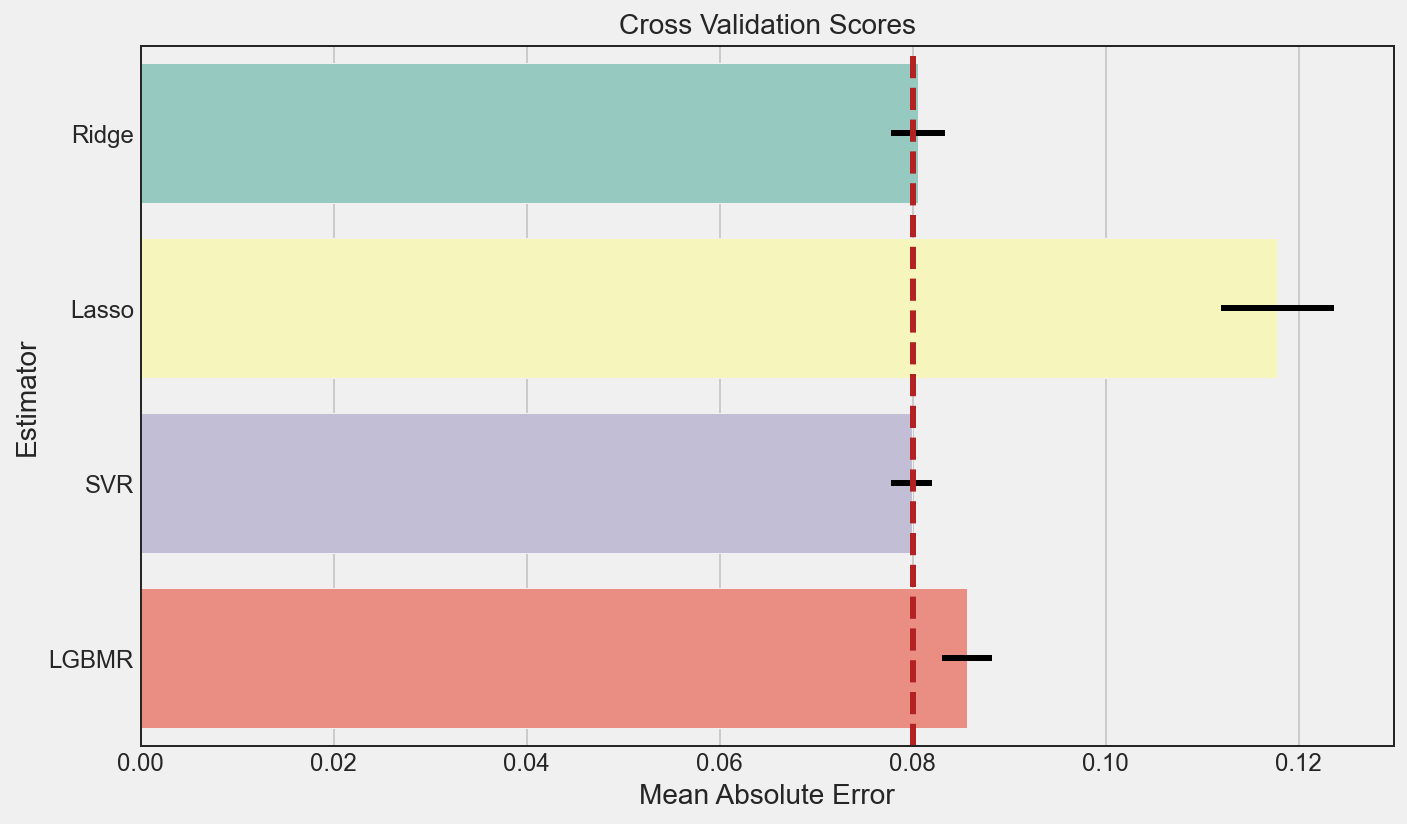

In [30]:
# Step 1: create a list containing all estimators with their default parameters
names = ['Ridge', 'Lasso', 'SVR', 'LGBMR']

estimators = [
    Ridge(random_state=random_state),
    Lasso(0.05, random_state=random_state),
    SVR(),
    LGBMRegressor(verbose=-1, random_state=random_state)
]

# Step 2: calculate the cv mean and standard deviation for each one of them
cv_base_mean, cv_std = [], []
for est in estimators:

    cv = cross_val_score(est,
                         X_train,
                         y_train,
                         scoring=scoring,
                         cv=5,
                         n_jobs=-1)
    cv_base_mean.append(-cv.mean())
    cv_std.append(cv.std())

# Step 3: create a dataframe and plot the mean with error bars
cv_baseline = pd.DataFrame({
    'Estimator': names,
    'CV-Means': cv_base_mean,
    'CV-Errors': cv_std
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='CV-Means',
            y='Estimator',
            data=cv_baseline,
            palette='Set3',
            orient='h',
            **{'xerr': cv_std},
            ax=ax)

ax.set_xlabel('Mean Absolute Error')
ax.set_title('Cross Validation Scores')
ax.axvline(x=0.08, color='firebrick', linestyle='--');

In [31]:
pd.set_option('precision', 5)
cv_baseline

,Estimator,CV-Means,CV-Errors
0,Ridge,0.08055,0.00280
1,Lasso,0.11779,0.00586
2,SVR,0.07988,0.00215
3,LGBMR,0.08562,0.00261


In [32]:
cv_tuned = {}

def Model_Performance(model_name, model):

    print(model_name)
    print('-----------------------------------------')
    print('        Best Score: ', str(-model.best_score_))
    print('   Best Parameters: ', str(model.best_params_))

    arg_min = np.argmin(model.cv_results_['rank_test_score'])
    scores_list = []
    for i in [
            'split0_test_score', 'split1_test_score', 'split2_test_score',
            'split3_test_score', 'split4_test_score'
    ]:
        scores_list.append(-model.cv_results_[i][arg_min])

    cv_tuned[model_name] = scores_list

print('Function ready!')

Function ready!


<br>

## Model Tuning

### Ridge

In [33]:
ridge = Ridge(random_state=random_state)

param_grid = {'alpha': [0.001, 0.1, 1, 10, 100, 1000]}

ridge_grid = GridSearchCV(ridge,
                          param_grid=param_grid,
                          cv=5,
                          scoring=scoring,
                          verbose=True,
                          n_jobs=-1)
best_grid_ridge = ridge_grid.fit(X_train, y_train)

Model_Performance('Ridge', best_grid_ridge)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ridge
-----------------------------------------
        Best Score:  0.07905658431639996
   Best Parameters:  {'alpha': 10}


### Lasso

In [34]:
ls = Lasso(random_state=random_state)

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

ls_grid = GridSearchCV(ls,
                       param_grid=param_grid,
                       cv=5,
                       scoring=scoring,
                       verbose=True,
                       n_jobs=-1)
best_grid_ls = ls_grid.fit(X_train, y_train)

Model_Performance('Lasso', best_grid_ls)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Lasso
-----------------------------------------
        Best Score:  0.07930855647049957
   Best Parameters:  {'alpha': 0.001}


### SVR

In [35]:
svr = SVR()

param_grid = {
    'kernel': ['rbf'],
#     'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1, 10],
    'C': [0.001, 0.1, 1, 10],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

svr_grid = GridSearchCV(svr,
                        param_grid=param_grid,
                        cv=5,
                        scoring=scoring,
                        verbose=True,
                        n_jobs=-1)
best_grid_svr = svr_grid.fit(X_train, y_train)

Model_Performance('SVR', best_grid_svr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
SVR
-----------------------------------------
        Best Score:  0.07379001365520314
   Best Parameters:  {'C': 1, 'coef0': 0, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}


### LGBMRegressor

In [36]:
lgbm = LGBMRegressor(verbose=-1, random_state=random_state)
param_grid = {
    'boosting_type': ['gbdt'],
    'n_estimators': [50, 100, 1000],
    'num_leaves': [31],
    'max_depth': [5, 10, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'feature_fraction': [0.4, 0.6, 0.8],
    'min_data_in_leaf': [5, 10, 20],
}

grid_lgbm = GridSearchCV(lgbm,
                         param_grid,
                         cv=5,
                         scoring=scoring,
                         verbose=True,
                         n_jobs=-1)

best_grid_lgbm = grid_lgbm.fit(X_train, y_train)

Model_Performance('LGBMRegressor', best_grid_lgbm)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
LGBMRegressor
-----------------------------------------
        Best Score:  0.07823728675511968
   Best Parameters:  {'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'min_data_in_leaf': 20, 'n_estimators': 1000, 'num_leaves': 31}


<br>

## Comparison

In [37]:
pd.set_option('precision', 5)

In [38]:
cv_tuned_mean = [np.mean(list(cv_tuned.items())[i][1]) for i in range(len(cv_tuned))]

cv_total = pd.DataFrame({
    'Algorithm': names,
    'Baseline': cv_base_mean,
    'Tuned Performance': cv_tuned_mean
})

cv_total.style.highlight_min(color='lightskyblue', axis=1)

,Algorithm,Baseline,Tuned Performance
0,Ridge,0.08055,0.07906
1,Lasso,0.11779,0.07931
2,SVR,0.07988,0.07379
3,LGBMR,0.08562,0.07824


In [39]:
colors = ['#7798AB', '#4D5061', '#FFA987', '#724E91', '#C297B8', '#FE4A49']
model_names = [list(cv_tuned.items())[i][0] for i in range(len(cv_tuned))]
scores = [list(cv_tuned.items())[i][1] for i in range(len(cv_tuned))]
score_medians = [np.round(np.median(list(cv_tuned.items())[i][1]), 4) for i in range(len(cv_tuned))]

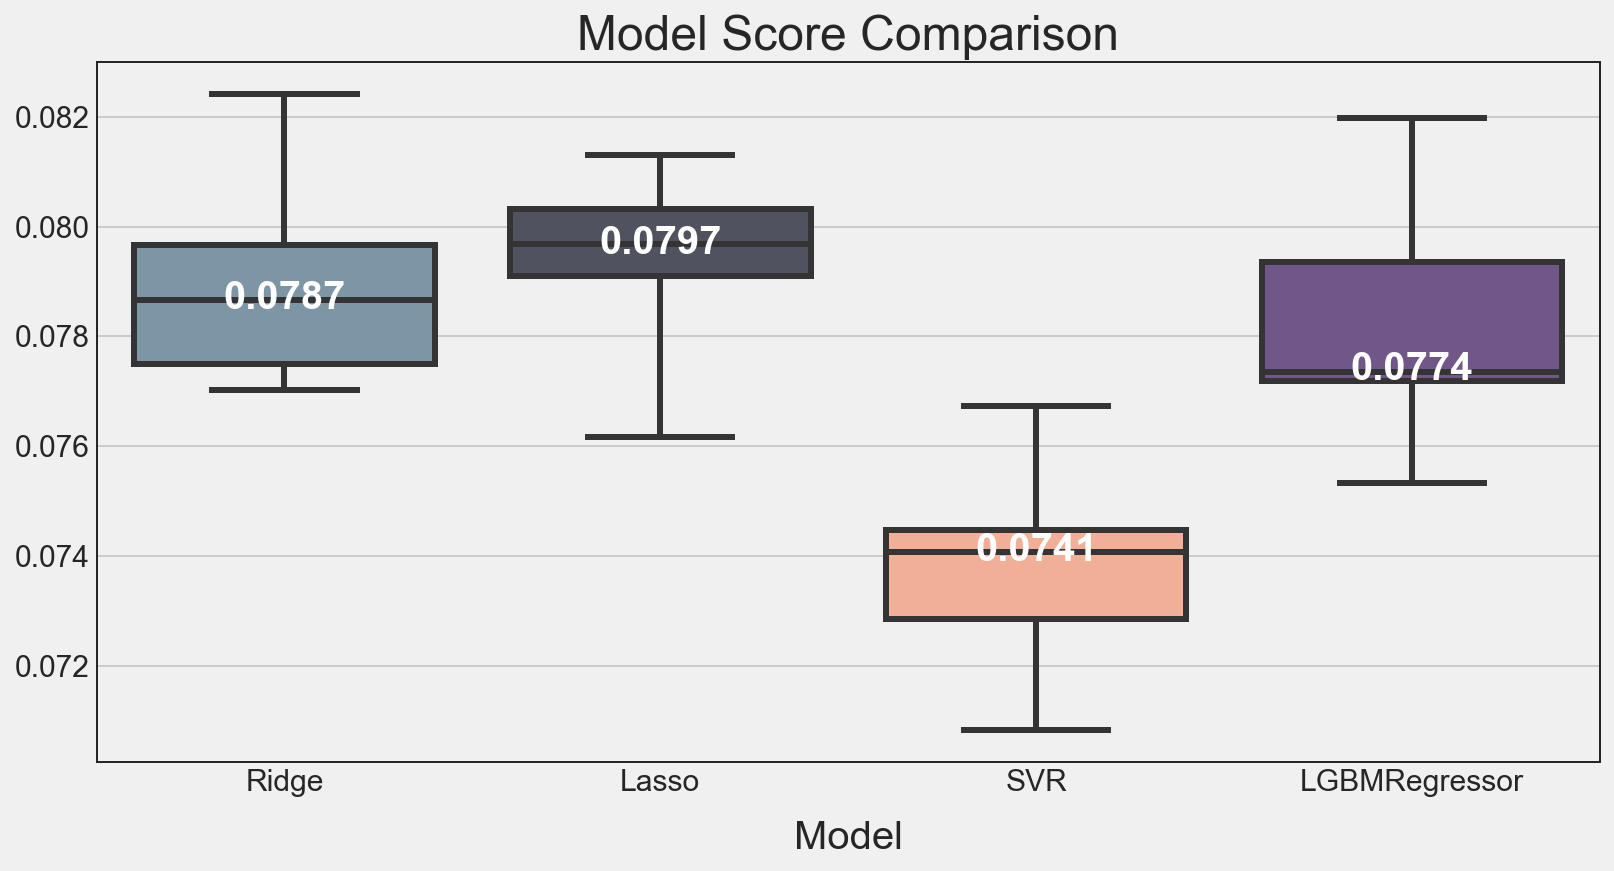

In [40]:
fig, ax = plt.subplots(figsize = (12, 6))

ax.set_title('Model Score Comparison', size = 24)
sns.boxplot(data = pd.DataFrame(cv_tuned), whis=2.5, palette = colors, ax = ax)

for xtick in ax.get_xticks():
    ax.text(xtick, score_medians[xtick] - 0.0002, score_medians[xtick],
            horizontalalignment = 'center', size = 20, color = 'w', weight = 'bold')
    
plt.xlabel('Model', size = 20, labelpad = 12)
plt.tick_params(axis = 'both', labelsize = 15);

<br>

## Feature Importance

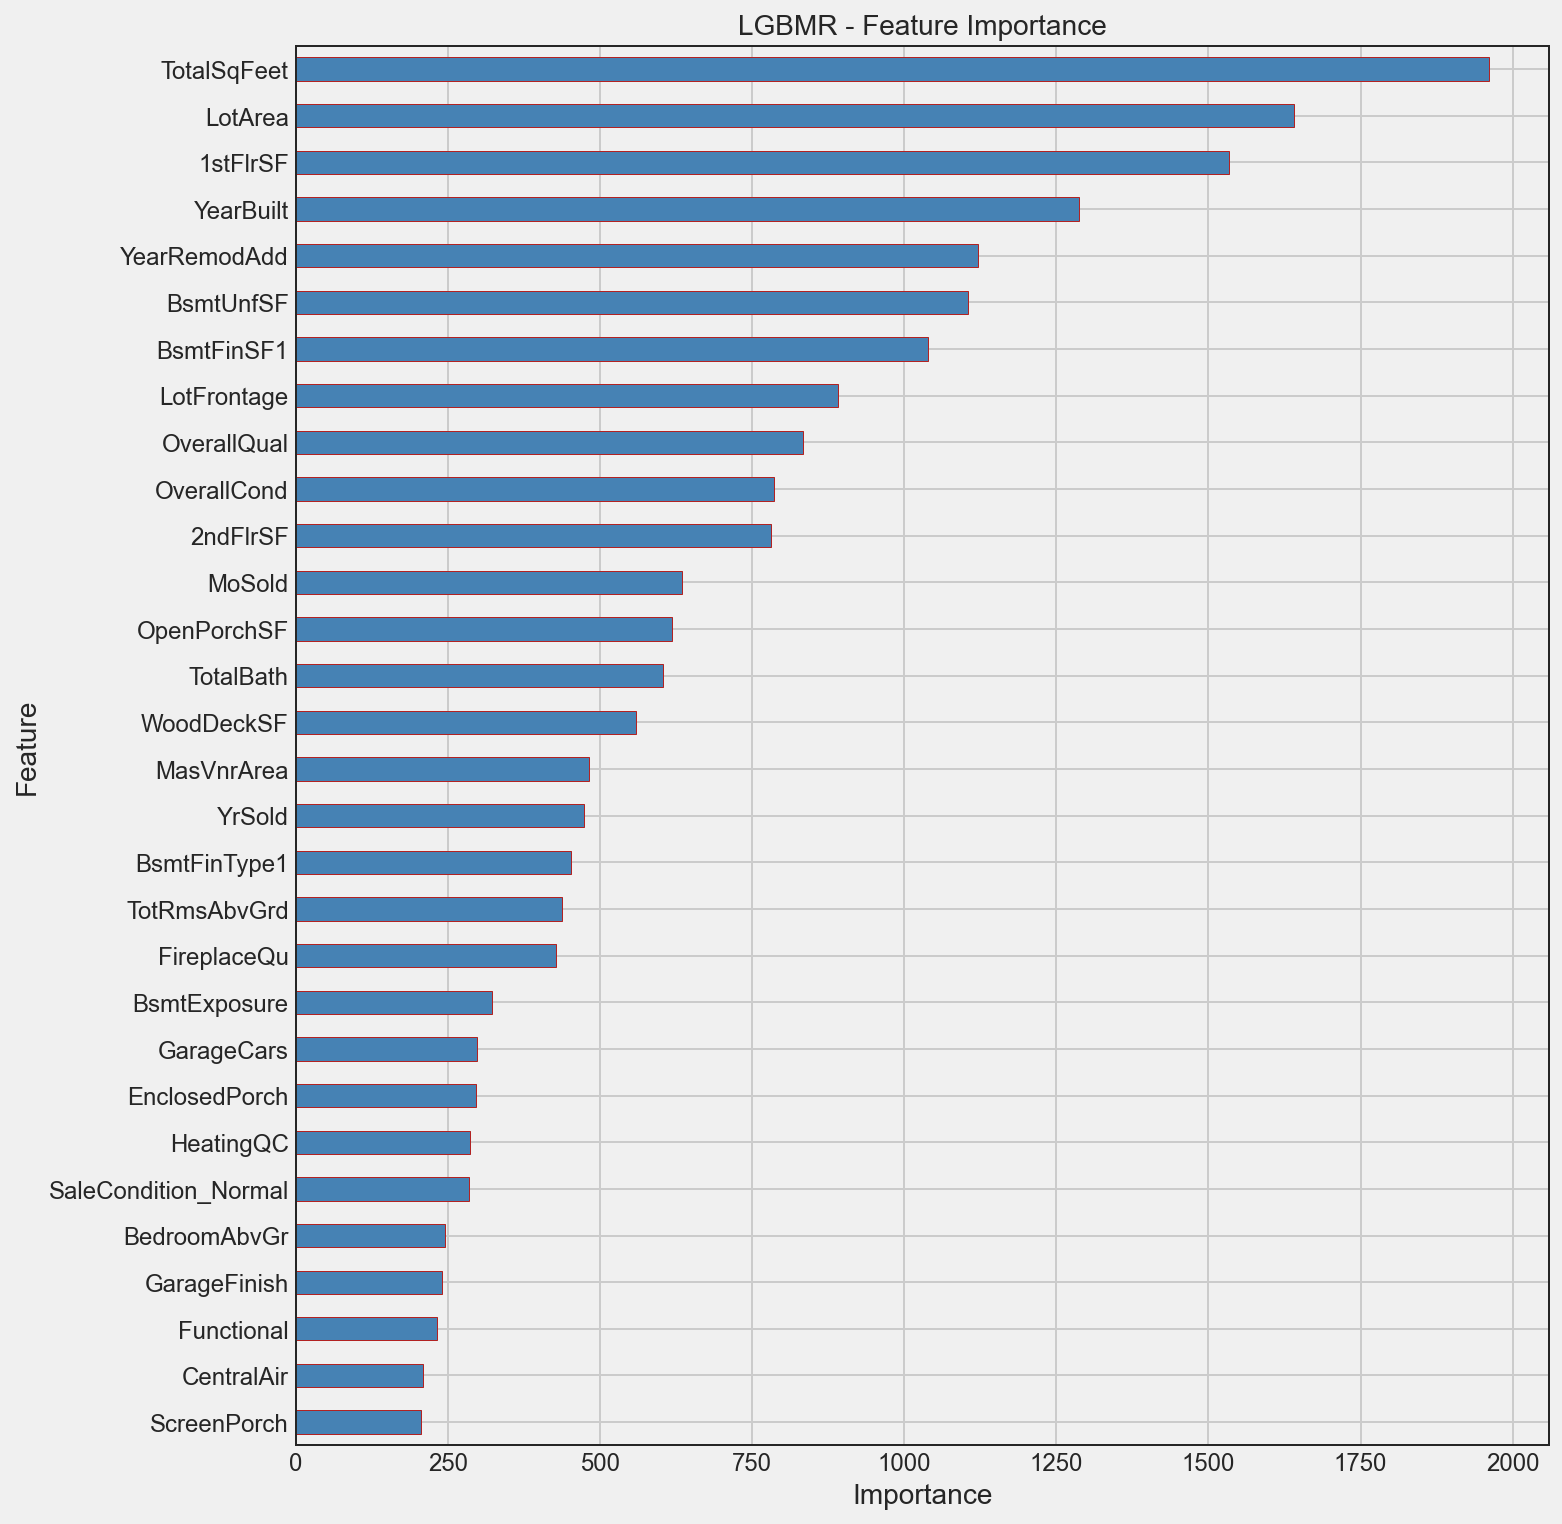

In [41]:
est = best_grid_lgbm.best_estimator_
n_features_vis = 30

feat_imp = pd.DataFrame({'Feature': X_train.columns,
                         'Importance': np.round(est.feature_importances_, 4)})

feat_imp = feat_imp.sort_values('Importance', ascending=False).set_index('Feature')
feat_imp = feat_imp.head(n_features_vis).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 12))

feat_imp.plot.barh(color='steelblue',
                   edgecolor='firebrick',
                   legend=False,
                   ax=ax)

ax.set(title='LGBMR - Feature Importance', xlabel='Importance');

<br>

# Test Set

In [42]:
best_estimators = [
    best_grid_ridge.best_estimator_, best_grid_ls.best_estimator_,
    best_grid_svr.best_estimator_, best_grid_lgbm.best_estimator_
]

for i, est in enumerate(best_estimators):
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    
    mae_test = mean_absolute_error(y_test, y_pred)
    
    print('{} - {}: {}'.format(i, names[i], np.round(mae_test, 3)))

0 - Ridge: 0.081
1 - Lasso: 0.081
2 - SVR: 0.075
3 - LGBMR: 0.08


In [43]:
for i, est in enumerate(best_estimators):
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    
    mae_test = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
    
    print('{} - {}: {}'.format(i, names[i], np.round(mae_test, 3)))

0 - Ridge: 13945.174
1 - Lasso: 14061.452
2 - SVR: 12960.152
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
3 - LGBMR: 13909.072


<br>

# Submission

In [45]:
# for i in range(len(best_estimators)):
#     est = best_estimators[i]
    
#     est.fit(X_train_original, y_train_original)

#     sub_df = pd.read_csv('sample_submission.csv')

#     y_pred = est.predict(X_test_original)
#     y_pred_trans = np.expm1(y_pred)

#     sub_df['SalePrice'] = y_pred_trans
#     sub_df.to_csv('20102021-{}.csv'.format(names[i]), index = False)

<br>

# References

<br>

# Conclusions